# SurvSHAP vs DeepLift vs Integrated Gradients
### K. Krajewski, M. Wojtala, S. Frejlak
## Experiment 1: Evaluating explanations on synthetic data

### Imports

In [21]:
# This code is useful if you want to make changes in any of the imported libraries, e.g. to solve compatibility issues.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch # For building the networks
import torchtuples as tt # Some useful functions

from pycox.models import DeepHitSingle
# from pycox.evaluation import EvalSurv

In [24]:
np.random.seed(1234)
_ = torch.manual_seed(123)

### Load a medical dataset and preprocess data

In [25]:
df_train = pd.read_csv('data/exp3_heart_failure_dataset.csv')
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [26]:
df_train.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [27]:
cols_standardize = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']
cols_leave = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [28]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [66]:
num_durations = 10

labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['time'].values, df['DEATH_EVENT'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

x_train.transpose()

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

### Create model and train it

In [71]:
in_features = x_train.shape[1]
num_nodes = [16, 16]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [72]:
model = DeepHitSingle(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

In [73]:
batch_size = 64
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

In [74]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 0.7055,	val_loss: 0.4378
1:	[0s / 0s],		train_loss: 0.4926,	val_loss: 0.4411
2:	[0s / 0s],		train_loss: 0.6027,	val_loss: 0.4344
3:	[0s / 0s],		train_loss: 0.4292,	val_loss: 0.4302
4:	[0s / 0s],		train_loss: 0.4303,	val_loss: 0.4290
5:	[0s / 0s],		train_loss: 0.4220,	val_loss: 0.4271
6:	[0s / 0s],		train_loss: 0.4219,	val_loss: 0.4262
7:	[0s / 0s],		train_loss: 0.3913,	val_loss: 0.4304
8:	[0s / 0s],		train_loss: 0.4023,	val_loss: 0.4387
9:	[0s / 0s],		train_loss: 0.3919,	val_loss: 0.4423
10:	[0s / 0s],		train_loss: 0.3698,	val_loss: 0.4378
11:	[0s / 0s],		train_loss: 0.3860,	val_loss: 0.4322
12:	[0s / 0s],		train_loss: 0.3554,	val_loss: 0.4278
13:	[0s / 0s],		train_loss: 0.3559,	val_loss: 0.4247
14:	[0s / 0s],		train_loss: 0.3595,	val_loss: 0.4244
15:	[0s / 0s],		train_loss: 0.3580,	val_loss: 0.4263
16:	[0s / 0s],		train_loss: 0.3325,	val_loss: 0.4288
17:	[0s / 0s],		train_loss: 0.3328,	val_loss: 0.4337
18:	[0s / 0s],		train_loss: 0.3364,	val_loss: 0.4377
19:

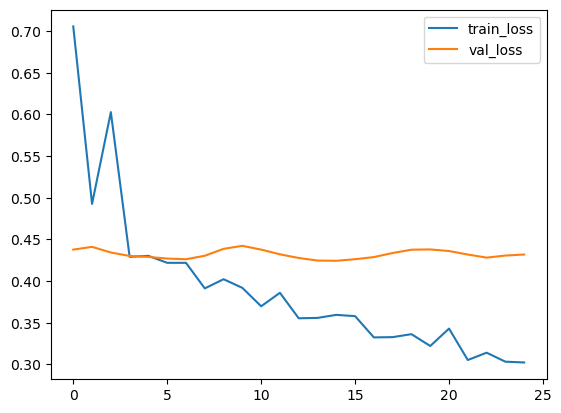

In [75]:
_ = log.plot()

### Model results analysis
This part is taken from the pycox tutorial

In [76]:
# print(log.to_pandas().val_loss.min())
# print(model.score_in_batches(val))
# surv = model.predict_surv_df(x_test)
# surv.iloc[:, :5].plot(drawstyle='steps-post')
# plt.ylabel('S(t | x)')
# _ = plt.xlabel('Time')

In [77]:
# surv = model.interpolate(10).predict_surv_df(x_test)
# surv.iloc[:, :5].plot(drawstyle='steps-post')
# plt.ylabel('S(t | x)')
# _ = plt.xlabel('Time')

In [78]:
# ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
# print(ev.concordance_td('antolini'))
# time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
# ev.brier_score(time_grid).plot()
# plt.ylabel('Brier score')
# _ = plt.xlabel('Time')

In [79]:
# print(ev.integrated_brier_score(time_grid))
# print(ev.integrated_nbll(time_grid))
# ev.nbll(time_grid).plot()
# plt.ylabel('NBLL')
# _ = plt.xlabel('Time')

### Explaining model's predictions
In this section we use explainers from captum library

In [80]:
from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
)

In [99]:
model.eval()
# baseline_dist = torch.zeros(191, 11, requires_grad=True) * 0.001
inputs = torch.tensor(x_train, requires_grad=True) #.unsqueeze(dim=0)
outputs = torch.tensor(y_train[1].astype('int64')) #, requires_grad=True)
dl = DeepLift(model.net)
ig = IntegratedGradients(model.net)
attributions, delta = ig.attribute(inputs, target=outputs, return_convergence_delta=True) #  baseline_dist, target=outputs,
print('Integrated Gradients mean attributions:', attributions.mean(dim=0).detach().numpy())
print('Mean Convergence Delta:', delta.mean().detach().numpy())
attributions, delta = dl.attribute(inputs, target=outputs, return_convergence_delta=True) #  baseline_dist, target=outputs,
print('DeepLift mean attributions:', attributions.mean(dim=0).detach().numpy())
print('Mean Convergence Delta:', delta.mean().detach().numpy())

Integrated Gradients mean attributions: [ 0.0292784   0.02505408 -0.03815171  0.01266383  0.01597387  0.06627826
 -0.03912117 -0.02868438  0.06274574  0.03201562  0.00618445]
Mean Convergence Delta: 0.0008815474739631148
DeepLift mean attributions: [ 0.02618182  0.01984281 -0.03617777  0.0109012   0.01511144  0.06467749
 -0.03416074 -0.02320135  0.05641534  0.03421191  0.00955333]
Mean Convergence Delta: 2.8476042e-09
